# Cluster Fixed Effects: Form Clusters Through Unsupervised Machine Learning

## Outline
- Understand and implement K-means clustering algorithm and group firms
- Conduct Principal Component Analysis (PCA) to perform dimentionality reduction and visualize the groupings
- Understand the benefits of using machine learning to group firms when defining fixed effects for regression models

If you have any comments or suggestions, email me at y.s.yoon@berkeley.edu.

## Introduction
In this notebook, I group US public firms by implementing the K-means unsupervised learning. 

The groups formed here are used when constructing fixed effects in my UC Berkeley Haas PhD Dissertation (<a href="https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3689446">Yoon 2022</a>). However, this code can be generalized and used in many other settings such as customer/market segmentation and recommendation systems.

## Goal: Group firms as shown in Figure 2
Figures 1 presents companies' seven characteristics shown in a 2-dimentional space after conducting dimentionality reduction. My goal is to group companies that share similar characteristics as shown in Figure 2.

![Before Grouping](image_pca_before.jpg)
![After Grouping](image_pca_after.jpg)

## Why is the machine learning approach beneficial?
In my dissertation, I study whether the new lease rule causes firms to reduce their leasing activity (e.g., discontinue a truck lease). To establish this causality between the new lease rule and firms' leasing activity, I need to eliminate other factors that can also affect lease use. For example, imagine that a group of automobile companies experienced a supply shock that resulted in a reduction of leasing activity. Because such shock is unrelated to the new lease rule, I need to nullify its  effects on leasing activity in order to study the effects of the new lease rule.

The fixed effects method is one of the popular ways to control for group-specific shocks. Going back to the previous example, because the group of automobile companies belong to the automobile industry, conducting industry fixed effects analysis would eliminate the automobile industry-specific shocks. In my dissertation, however, industry grouping may not be adequate because leasing decisions depend on various firm characteristics and not just an industry membership. If the relationships between firm characteristics and leasing decisions are perfectly linear, then adding firm characteristics as control variables should be sufficient. However, since that is unlikely the case, adding fixed effects of groups generated through firm characteristics provides an incremental benefit.

One way to form groups is to transform all firm characteristics to high/low values and group firms with similar values. For example, I can form two groups based on high/low values of firm size or four groups based on high/low values of firm size and past leasing activity. However, the challenge is that I have a lot more than 2 firm characterics and I don't know how many groups is an adequate number. To overcome this challenge, I let the computer conduct unsupervised learning on my data and help me decide how to form groups.


## K-means clustering
The K-means clustering algorithm is one of the most popular unsupervised machine learning algorithms to form groups. A cluster refers to a group of similar things close to each other. The main goal of the algorithm is to find clusters that minimize the distances between points within clusters. I use Python's Scikit-learn library to implement the algorithm, but here is what's going on behind the scenes. 

#### K-means clustering implementation steps (apply Lloyd’s algorithm)
Step 1: Choose the number of clusters (k) using the elbow method.<br>
Step 2: Randomly place k centroids in the data space.<br>
Step 3: Calculate the Euclidean distance between data points and centroids.<br>
Step 4: Assign each data point to the nearest centroids. Clusters are formed at this step.<br>
Step 5: Recalculate the centroid of the clusters (i.e., average the data - where the name K-'means' comes from).<br>
Step 6: Repeat steps 4 and 5.

Stop the loop when one or more of the following is true:<br>
(1) Centroids of new clusters no longer change.<br>
(2) The same data points are assigned to the same centroids.<br>
(3) A pre-specified maximum number of iterations are reached.

## Data
#### Input Data
The data "characteristics.csv" contains US public firms' characteristics that are related to leases. They are averaged across the 3-year period from 2016 to 2018.

#### Output data
The code will output a list of companies along with a cluster assignment.

#### Feature definition (for details, see <a href="https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3689446">Yoon 2022</a>)
lag_lease: prior year's lease activity<br>
lag_market_value: prior year's market capitalization of the stock<br>
lag_dividend: an indicator value that equals 1 if the company paid any dividends in the prior, and 0 otherwise<br>
lag_loss: an indicator value that equals 1 if the company reported negative profits in the prior year<br>
lag_cash: prior year's cash balance<br>
lag_tax_rate: effective tax rate in the prior year<br>
lag_big4_auditor: an indicator value that equals 1 if the company hired a Big 4 auditor in the prior year<br>

## Implementing K-means clustering in Python (Scikit-learn)


### 1. Setup


In [72]:
# Import libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.decomposition import PCA

In [73]:
# Import the csv file
characteristics = pd.read_csv('characteristics.csv')

### 2. Conduct an Exploratory Data Analysis (EDA)

#### Show the first 5 entries in the data

In [74]:
# First 5 entries
characteristics.head()

,identifier,lag_lease,lag_market_value,lag_dividend,lag_loss,lag_cash,lag_tax_rate,lag_big4_auditor
0,1004,1.566298,6.926615,0.007283,0.0,0.021530,0.359131,1.0
1,1050,0.810631,5.635750,0.016376,1.0,0.076807,0.350014,0.0
2,1072,0.194303,7.785037,0.028557,0.0,0.394580,0.167300,1.0
3,1078,0.320986,11.183587,0.030134,0.0,0.210340,0.371148,1.0
4,1104,1.091098,4.292186,0.014084,0.0,0.058464,0.342861,0.0


#### The # of variables and entries
There are<br>
a total of 8 variables = 1 identifier + 7 firm characteristics (features) and<br>
a total of 1640 entries, which are all unique firm entries.

In [75]:
# (Number of entries, Number of features)
characteristics.shape

(1640, 8)

In [76]:
# The number of unique firms
characteristics['identifier'].nunique()

1640

#### Remove the identifier
Because we don't need the identifier column for the analysis, I will create a new dataframe without it

In [77]:
# Create a sample to conduct the analysis
sample = characteristics.drop(columns=['identifier'])

#### Descriptive stats (empirical distributions, histograms, and correlation plots)
A few observations:
- There are no missing values (all counts equal 1640).<br>
- Features do not have outliers. This is important because one of the disadvantages of K-means clustering is that centroids can be significantly affected by outliers instead of being ignored.
- lag_lease,  lag_dividend, lag_cash are right-skewed, which make economic sense.<br>
- lag_market_value follows a normal distribution.<br>
- The lag_tax_rate values are clustered around 35%.<br>

Bottom line, this is a clean data with values that make economic sense.

For simplicity, I do not provide a detailed explanations of the data. See <a href="https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3689446">Yoon (2022)</a> for more details. 


In [78]:
# Show empirical distributions
sample.describe()

,lag_lease,lag_market_value,lag_dividend,lag_loss,lag_cash,lag_tax_rate,lag_big4_auditor
count,1640.000000,1640.000000,1640.000000,1640.000000,1640.000000,1640.000000,1640.000000
mean,1.786803,7.542243,0.016611,0.259045,0.204958,0.276199,0.815752
std,2.642125,1.730802,0.027882,0.382068,0.226048,0.108693,0.381615
min,0.032784,3.697241,0.000000,0.000000,0.000878,0.000101,0.000000
25%,0.466649,6.387482,0.000000,0.000000,0.047117,0.232194,1.000000
50%,0.874767,7.455973,0.001367,0.000000,0.119014,0.349967,1.000000
75%,1.824188,8.653680,0.023156,0.333333,0.272314,0.350238,1.000000
max,15.683336,12.116967,0.172973,1.000000,0.959124,0.372000,1.000000


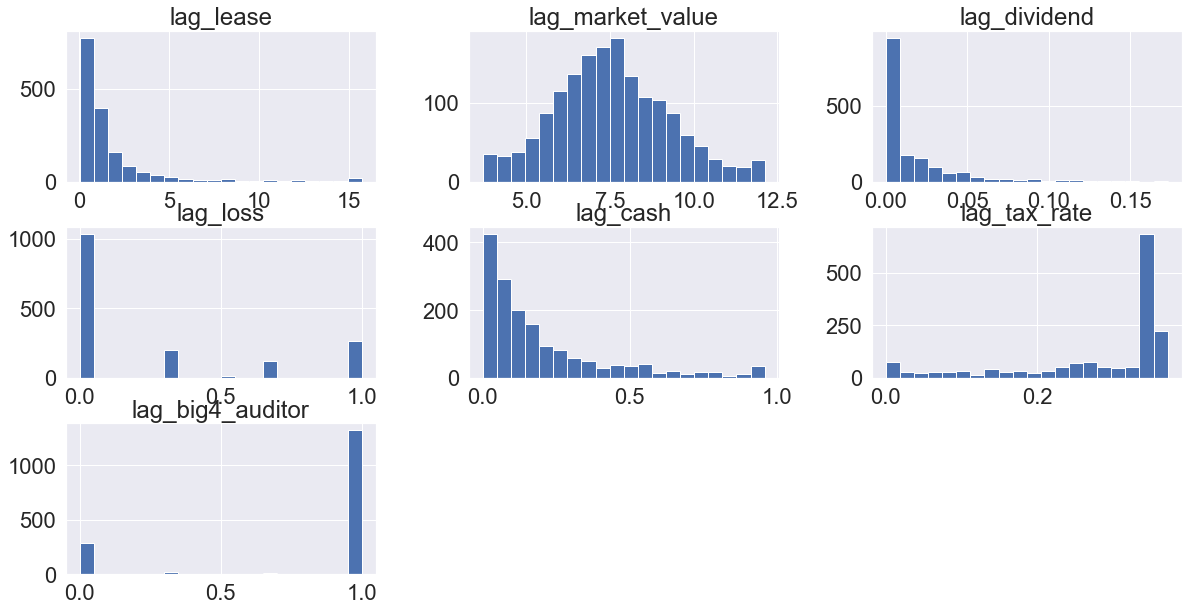

In [79]:
# Show histograms
sample.hist(bins = 20, figsize =(20, 10))
plt.show()

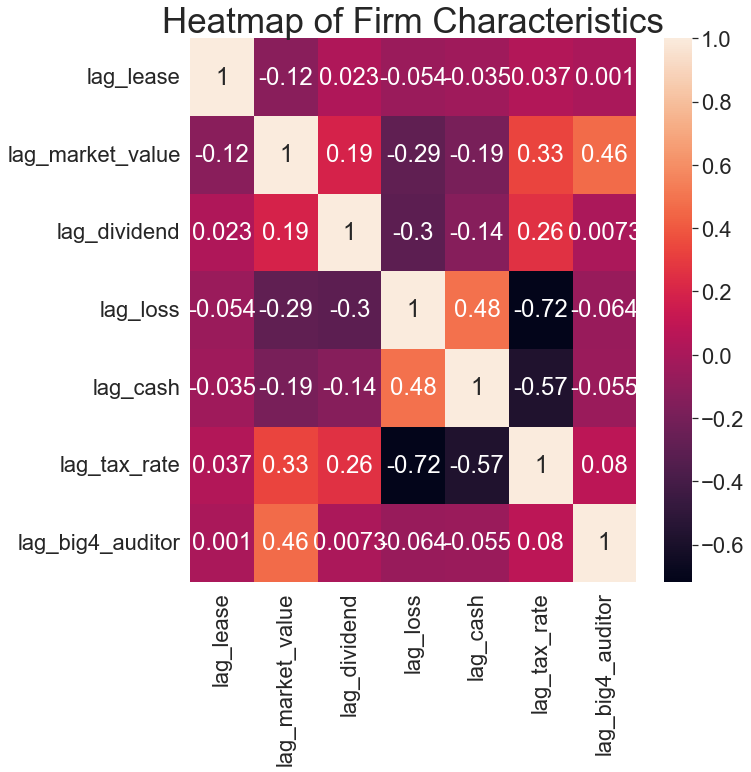

In [80]:
# Plot correlation heatmap
correlations = sample.corr()                                # Compute correlations
f, ax = plt.subplots(figsize=(10,10))                       # Adjust figure size
sns.heatmap(correlations, annot=True)                       # Create a heatmap
sns.set(font_scale=2)                                       # Adjust font size
plt.title('Heatmap of Firm Characteristics', fontsize = 35) # Title
plt.show()

### 3. K-Means Clustering
#### Feature engineering - Standarizing the features
Because I want to minimize within-cluster euclidean distances, it is important to standarize features first.


In [81]:
# Standardize features
sample_scaled = StandardScaler().fit_transform(sample)

###### The Elbow Method

One disadvantage of K-means clustering is that we have to choose k manually. But we can choose k intellectually by using the Elbow method, one of the most popular and effective method.

In the Elbow method, we are going to gradually increase k from 1 and plot inertia across k. Inertia refers to the within-cluster sum of squared distances from centroids. As shown in the figure below, the line resembles an arm. We see that starting at around k=4, the line flattens out. In other words, k=4 seems to be the "elbow point". In my disseration, I use k=4, 6, and 8  to assure that my results are not sensitive to the choice of k. 

#### K-Means++
The second disadvantage of K-means clustering is that it depends on initial value of centroid. If you run the following code a couple of times, you will notices that the lines change slightly. To overcome this challenge, we can use K-Means++. Unlike K-means that randomly select all of k centroid's inital points, K-Means++ randomly selects first centroid point and select the next centroid as the data point that has the maximum distance from the nearest centroid. This algorithm repeats until k centroids have been selected. The main idea is to select centorids that are far away from one another so that centroids are more likely located in different clusters.


C:\Users\Young\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=7.
  warnings.warn(


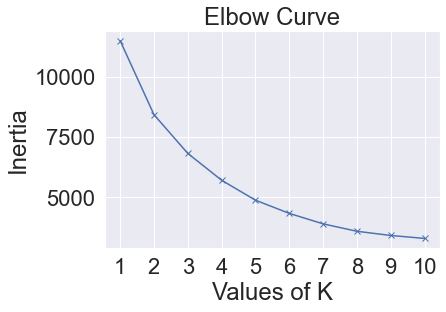

In [82]:
# Initialize inertia
inertia = []

# Calculate inertia for k=[1:10]
for i in range(1,11):                   # i ranges from 1 to 10
    kmeans = KMeans(n_clusters = i,     # Assign i number of clusters
                    init='k-means++',   # Use K-Means++ as the initialization method
                    max_iter=1000)      # Set maximum # of iterations
    kmeans.fit(sample_scaled)           # Fitting the k means algorithm
    inertia.append(kmeans.inertia_)     # Record inertia (the sum of squared distances to centroids)
    
# Plot the inertia across k
plt.plot(inertia, 'bx-')
plt.xticks(list(range(0,10)),list(range(1,11)))   # Change the x ticks from 0:8 to 0:9
plt.xlabel('Values of K') 
plt.ylabel('Inertia')        
plt.title('Elbow Curve')    
plt.show()


#### Implement K-means clustering
Now that we have chosen to use K=4 clusters, we can implement K-means clustering and group firms

In [83]:
# Select k=4
kmeans = KMeans(n_clusters = 4,         # Assign i number of clusters
                    init='k-means++',   # Use K-Means++ as the initialization method
                    max_iter=1000)      # Set maximum # of iterations

# fitting the k means algorithm
kmeans.fit(sample_scaled)

# Get cluster assignemnts
labels = kmeans.labels_


### 4. Principal Component Analysis (PCA) - Visualize Clusters
Before I export the cluster assignments and use them to conduct fixed effects analysis, I visualize clusters by conducting a principal component analysis.

#### Conduct PCA
It is very difficult to visualize seven features that I have in my data. To better visualize 7 dimentional data, I will first reduce it to 2 dimentional data in the following code.

In [84]:
# Add identifiers and cluster assignments (labels) to the sample
sample = pd.concat([characteristics['identifier'], sample, pd.DataFrame({'cluster':labels})], axis=1)

# Conduct PCA
pca = PCA(n_components=2)                          # The number of components
principal_comp = pca.fit_transform(sample_scaled)  # Conduct dimentionality reduction

# Create a dataframe and add a column of labels (cluster assignments)
pca_df = pd.DataFrame(data = principal_comp, columns = ['principal_component1', 'principal_component2'])
pca_df = pd.concat([pca_df, pd.DataFrame({'Cluster':labels})], axis = 1)      # Add a column of labels

# Show the first 5 firms
pca_df.head()


,principal_component1,principal_component2,Cluster
0,-0.990592,0.261629,1
1,1.170472,1.843412,2
2,0.316073,-0.778761,1
3,-1.778196,-1.366739,1
4,0.097569,2.826009,2


#### Plot the two principal components
The following code plots the two principal components. Note that each component do not have a particular meaning.

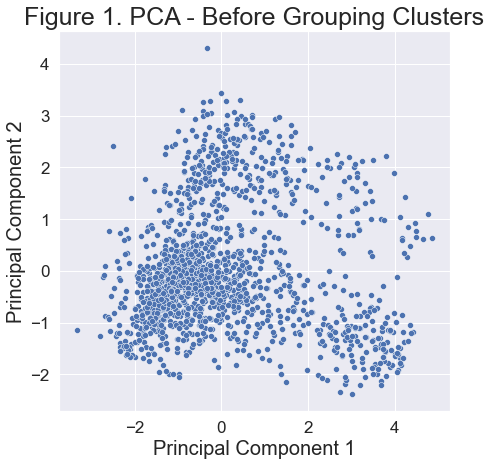

In [97]:
# Create a scatter plot of two components
plt.figure(figsize=(7,7))                                         # figure size
ax = sns.scatterplot(
    x="principal_component1", y="principal_component2",                    
    data = pca_df)                                                # plot
plt.xlabel("Principal Component 1", size=20)                      # x label
plt.ylabel("Principal Component 2", size=20)                      # y label
plt.xticks(fontsize=17)                                           # x tick
plt.yticks(fontsize=17)                                           # y tick
plt.title("Figure 1. PCA - Before Grouping Clusters", size=25)    # title
plt.show()

#### Show clusters
Using the cluster assignments, we can group the points in clusters. Let's visualize them.

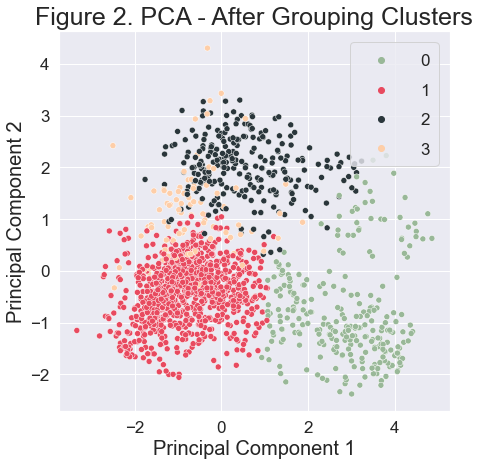

In [102]:
# Create a scatter plot of two components and group them into clusters
plt.figure(figsize=(7,7))                                      # figure size
ax = sns.scatterplot(
    x="principal_component1", y="principal_component2",                    
    hue = "Cluster", 
    data = pca_df, 
    palette = ['#99B898', '#E84A5F', '#2A363B', '#FECEA8'])     # Scatter Plot
plt.legend(loc='upper right')                                   # Legend position
plt.setp(ax.get_legend().get_texts(), fontsize='17')            # legend text
plt.setp(ax.get_legend().get_title(), fontsize='17')            # legend title
plt.xlabel("Principal Component 1", size=20)                    # x label
plt.ylabel("Principal Component 2", size=20)                    # y label
plt.xticks(fontsize=17)                                         # x tick
plt.yticks(fontsize=17)                                         # y tick
plt.title("Figure 2. PCA - After Grouping Clusters", size=25)   # Figure title
plt.show()


### 5. Export to csv
I am going to use this

In [208]:
sample.to_csv('characteristics_with_clusters.csv')